# Multi-sample context-specific metabolic networks from transcriptomics

Here we show the data processing step for the evaluation of the method. We used the Yeast-GEM v8.5.0 from https://github.com/SysBioChalmers/yeast-GEM and gene expression data from https://deleteome.holstegelab.nl/

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import pyarrow
import seaborn as sns
import sklearn as sl

pd.__version__, np.__version__, pyarrow.__version__, sns.__version__, sl.__version__

('2.2.3', '1.26.4', '18.1.0', '0.13.2', '1.4.2')

In [2]:
# Import Yeast 8.5.0 metabolic network annotations from SysBioChalmers github
df_yeastn = pd.read_csv("https://raw.githubusercontent.com/SysBioChalmers/yeast-GEM/v8.5.0/model/yeast-GEM.txt", sep="\t")
df_yeastn["Gene-reaction association"] = df_yeastn["Gene-reaction association"].str.replace('-','_')
df_yeastn

,Rxn name,Formula,Gene-reaction association,LB,UB,Objective
0,r_0001,s_0025[c] + 2 s_0709[m] -> 2 s_0710[m] + s_13...,(( YDL174C and YEL039C ) or ( YDL174C and YJR0...,0.0,1000.0,0.0
1,r_0002,s_0027[m] + 2 s_0709[m] -> 2 s_0710[m] + s_14...,(( YDL178W and YEL039C ) or ( YDL178W and YJR0...,0.0,1000.0,0.0
2,r_0003,s_0035[c] + s_1198[c] <=> s_0020[c] + s_0794[...,YAL060W,-1000.0,1000.0,0.0
3,r_0004,s_0063[c] + 2 s_0709[m] -> 2 s_0710[m] + s_13...,(( YEL039C and YML054C ) or ( YJR048W and YML0...,0.0,1000.0,0.0
4,r_0005,s_1543[c] -> s_0001[ce] + s_0794[c] + s_1538[c],( YGR032W or YMR306W or ( YLR342W and YCR034W )),0.0,1000.0,0.0
...,...,...,...,...,...,...
4053,r_4694,s_4258[c] -> s_4259[e],NaN,0.0,1000.0,0.0
4054,r_4695,s_4259[e] ->,NaN,0.0,1000.0,0.0
4055,r_4697,s_4253[m] <=> s_4261[c],NaN,-1000.0,1000.0,0.0
4056,r_4698,s_4261[c] -> s_4262[e],NaN,0.0,1000.0,0.0


In [3]:
# Get the GPR genes
genes = df_yeastn['Gene-reaction association'].str.findall(r'Y[A-Z]{2}\d{3}[A-Z]')
yeast_gem_genes = set()
for glist in genes:
    if isinstance(glist, list):
        yeast_gem_genes |= set(glist)
len(yeast_gem_genes)

1140

In [4]:
# Load the expression data from yeast mutants
df = pd.read_csv("https://deleteome.holstegelab.nl/data/downloads/deleteome_responsive_mutants_ex_wt_var_controls.txt", sep="\t", header=[0, 1])
new_levels = []

for level in df.columns.levels[1]:
    match = re.search(r'Unnamed: (\d+)_level_1', level)
    if match:
        new_levels.append(f'sym{match.group(1)}')
    else:
        new_levels.append(level)

df.columns = df.columns.set_levels(new_levels, level=1)
df.head()

reporterId systematicName geneSymbol vps25-del vs. wt                      \
     dataType           sym1       sym2                A         M   p_value   
0  SCAB000001          Q0010      Q0010         5.823057  0.035863  0.813902   
1  SCAB000002          Q0017      Q0017         5.864305  0.031833  0.788110   
2  SCAB000003          Q0032      Q0032         5.824237 -0.036730  0.799512   
3  SCAB000004          Q0045       COX1         6.814895 -0.214972  0.148581   
4  SCAB000007          Q0060        AI3         7.696378 -0.511059  0.054671   

  opi3-del vs. wt                     cho2-del vs. wt  ... usa1-del vs. wt  \
                A         M   p_value               A  ...         p_value   
0        5.740183 -0.040396  0.397733        5.702055  ...        0.980460   
1        5.714899 -0.061949  0.156009        5.714209  ...        0.904008   
2        5.858313 -0.053242  0.459498        5.916502  ...        0.982628   
3        6.175338 -0.096895  0.135788        6.787510  ...        0.993181   
4        7.514641  0.422836  0.001982        7.629467  ...        0.937841   

  wt-matA vs wt                     wt-by4743 vs. wt                      \
              A         M   p_value                A         M   p_value   
0      5.641819 -0.017202  0.265474         5.768842  0.008386  0.912020   
1      5.651873 -0.011236  0.417339         5.845863  0.010049  0.897931   
2      5.752928 -0.012401  0.568422         5.865916  0.013855  0.905891   
3      6.365418 -0.010878  0.605649         6.610040 -0.210424  0.004053   
4      7.248474 -0.079449  0.068678         7.856393  0.183112  0.332364   

  wt-ypd vs. wt                      
              A         M   p_value  
0      5.600768 -0.029101  0.616744  
1      5.602166 -0.012800  0.835180  
2      5.672766 -0.007500  0.943031  
3      5.968052 -0.160800  0.019957  
4      6.506251 -0.891300  0.000000  

[5 rows x 2112 columns]

In [6]:
# Extract the M, A and P-vals calculated from microarray data
df_pvals_all = pd.concat([df.xs('sym1', axis=1, level=1), df.xs('p_value', axis=1, level=1)], axis=1).set_index("systematicName")
df_mvals_all = pd.concat([df.xs('sym1', axis=1, level=1), df.xs('M', axis=1, level=1)], axis=1).set_index("systematicName")
df_avals_all = pd.concat([df.xs('sym1', axis=1, level=1), df.xs('A', axis=1, level=1)], axis=1).set_index("systematicName")
df_ratio_all = df_mvals_all/df_avals_all
df_mvals_all

,vps25-del vs. wt,opi3-del vs. wt,cho2-del vs. wt,ctk1-del vs. wt,hpa1-del-matA vs. wt-matA,nup133-del-matA vs. wt-matA,ctf8-del vs. wt,doa4-del vs. wt,bre2-del-matA vs. wt-matA,swd1-del-matA vs. wt-matA,...,rim15-del vs. wt,cmk2-del vs. wt,lcb5-del vs. wt,cka1-del vs. wt,psr1-del vs. wt,ppg1-del vs. wt,usa1-del vs. wt,wt-matA vs wt,wt-by4743 vs. wt,wt-ypd vs. wt
systematicName,,,,,,,,,,,,,,,,,,,,,
Q0010,0.035863,-0.040396,-0.058408,-0.176650,0.045415,-0.002167,-0.017528,0.027805,0.006521,0.007683,...,-0.045099,0.016796,0.020001,0.011696,0.029107,0.042896,-0.014000,-0.017202,0.008386,-0.029101
Q0017,0.031833,-0.061949,-0.032521,-0.100209,-0.006401,-0.016251,-0.035365,-0.015726,-0.052527,-0.093276,...,0.019303,-0.015600,-0.027800,-0.009200,-0.011200,0.019104,-0.032200,-0.011236,0.010049,-0.012800
Q0032,-0.036730,-0.053242,-0.120856,-0.433867,-0.029716,0.071392,-0.029463,-0.045053,0.015440,-0.020263,...,0.133695,0.020996,-0.039300,0.058594,0.009405,0.048404,-0.011700,-0.012401,0.013855,-0.007500
Q0045,-0.214972,-0.096895,-0.251795,0.713361,0.076600,0.241511,0.218459,-0.114908,-1.047893,-0.805787,...,0.228098,-0.076600,-0.196100,-0.035800,0.190198,0.096599,0.006104,-0.010878,-0.210424,-0.160800
Q0060,-0.511059,0.422836,0.112193,0.538846,0.760221,0.003832,0.393109,-0.879261,-0.308523,0.022389,...,0.461005,0.621599,-0.755800,0.120803,0.018406,0.280897,-0.079300,-0.079449,0.183112,-0.891300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YNL162W-A,-0.291491,-0.672248,-0.601483,-0.227231,-0.106753,-0.380873,-0.098286,-0.216872,0.182463,0.213565,...,0.239300,0.007999,0.093601,0.073505,0.198896,0.041397,-0.059400,0.041355,0.057124,0.013098
YNR001W-A,-0.039847,-0.130058,-0.093074,-0.522016,-0.036877,-0.117841,-0.017126,-0.128104,-0.060627,-0.027404,...,0.015398,-0.012601,0.086906,0.004394,0.007899,-0.016101,-0.006300,0.004178,0.041285,-0.015901
YNR034W-A,1.530955,3.174498,2.581127,2.073022,-0.224273,1.261429,0.197148,0.756981,-0.213363,-0.125228,...,0.045695,-0.173601,-0.209900,-0.005900,-0.214900,0.577596,0.050202,-0.148594,-0.234240,-0.423101


(703, 2)


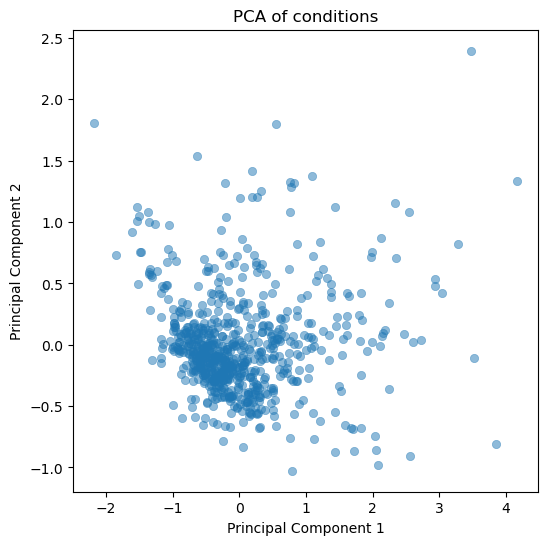

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


# Standardizing the data
scaler = StandardScaler()
scaled_df = df_ratio_all.T #scaler.fit_transform(df_ratio_all.T)

# Applying PCA
pca = PCA(n_components=2)  # Adjust n_components as needed
pca_result = pca.fit_transform(scaled_df)
print(pca_result.shape)
pca_df = pd.DataFrame(data = pca_result, columns = ['PC1', 'PC2'])

# Plotting
plt.figure(figsize=(6,6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, edgecolor=None, alpha=0.5)
plt.title('PCA of conditions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [8]:
# Change col names
def map_ids(df, file='ko-genes-ids.csv', sep=" "):
    df_gid = pd.read_csv(file, sep=sep)
    new_cols = []
    mapping_cols = dict()
    for c in df.columns.get_level_values(0):
        gid = ()
        if "vs" in c:
            # extract the gene name (e.g vps25-del vs. wt -> vps25)
            gsymbol = c.split("vs")[0].strip().split("-")[0].upper()
            # if the gene is in the mapping file, get the associated identifier
            if (df_gid.input.str.upper() == gsymbol).any():
                gid = (gsymbol, df_gid[df_gid.input.str.upper() == gsymbol].secondaryIdentifier.values.tolist()[0])
            else:
                gid = (gsymbol, None)
        mapping_cols[c] = gid
    return mapping_cols

mapped_col_genes = map_ids(df)
mapped_col_genes['vps25-del vs. wt']

('VPS25', 'YJR102C')

In [9]:
gene_col = {mapped_col_genes[k][1]: k for k in mapped_col_genes if len(mapped_col_genes[k])==2 and mapped_col_genes[k] and isinstance(mapped_col_genes[k][1], str)}

In [10]:
intervened_genes = {mapped_col_genes[k][1] for k in mapped_col_genes if len(mapped_col_genes[k])==2 and mapped_col_genes[k] and isinstance(mapped_col_genes[k][1], str)}

In [11]:
# Get the values of the KO genes in conditions where they were not knocked out
ko_genes_no_intervention_values = dict()
for k in intervened_genes:
    if k in df_ratio_all.index:
        ko_genes_no_intervention_values[k] = df_ratio_all.drop(gene_col[k], axis=1).loc[k, :].values.tolist()
df_noint_values = pd.DataFrame(ko_genes_no_intervention_values)

In [12]:
ko_genes_int_values = []
for k in ko_genes_no_intervention_values:
    ko_genes_int_values.append((k, df_ratio_all.loc[k, gene_col[k]]))
df_ko_genes_int_values = pd.DataFrame(ko_genes_int_values, columns=["gene", "ko_ma_ratio"]).set_index("gene")
df_ko_genes_int_values

,ko_ma_ratio
gene,
YML107C,-0.230621
YDL213C,-0.500915
YMR231W,-0.367627
YJL204C,-0.253360
YDL076C,-0.297197
...,...
YPR023C,-0.362762
YNL097C,-0.348026
YDR079C-A,-0.212610


In [13]:
# Select only the efficient conditions (ko gene M/A ratio below the non ko conditions)
# Same condition as in "Methods for causal inference from gene perturbation experiments and validation"

efficient_kos = set()
for ko_g, r in df_ko_genes_int_values.iterrows():
    min_obs = df_noint_values.loc[:, ko_g].min()
    if r.ko_ma_ratio < min_obs:
        efficient_kos.add(ko_g)
len(efficient_kos)

668

In [14]:
ko_metabolic_genes = yeast_gem_genes.intersection(efficient_kos)
ko_metabolic_gene_cols = list({gene_col[k] for k in ko_metabolic_genes})
len(ko_metabolic_genes)

46

In [15]:
met_genes = df_mvals_all.index.intersection(yeast_gem_genes)
len(met_genes)

1099

In [16]:
# Subset the dfs for metabolic genes and metabolic KOs
df_mvals = df_mvals_all.loc[met_genes, ko_metabolic_gene_cols]
df_avals = df_avals_all.loc[met_genes, ko_metabolic_gene_cols]
df_pvals = df_pvals_all.loc[met_genes, ko_metabolic_gene_cols]
df_ratio = df_ratio_all.loc[met_genes, ko_metabolic_gene_cols]

In [17]:
# Filter 2: use p-val and quantiles on M/A ration, and compute proportion of genes per condition that fall outside the ranges
# NOTE: The criteria can be relaxed, resulting in more conditions to analyze. Here we focus on the top most affected by the KO's at the metabolic level
pval_th = 1e-2
th_qlow = df_ratio_all.stack().quantile(0.025)
th_qhigh = df_ratio_all.stack().quantile(0.975)
min_proportion = 0.15

df_proportion_per_condition = ((df_pvals <= pval_th) & ((df_ratio <= th_qlow) | (df_ratio >= th_qhigh))).mean(axis=0).sort_values(ascending=False)

# Select conditions with at least 15% of perturbed metabolic genes
df_conditions = df_proportion_per_condition[df_proportion_per_condition >= min_proportion]
selected_conditions = df_conditions.index
df_conditions

opi3-del vs. wt     0.499091
ram1-del vs. wt     0.400909
cho2-del vs. wt     0.325455
aco1-del vs. wt     0.322727
pfk2-del vs. wt     0.210000
ipk1-del vs. wt     0.203636
vps15-del vs. wt    0.201818
sis2-del vs. wt     0.196364
arg82-del vs. wt    0.189091
plc1-del vs. wt     0.186364
rnr4-del vs. wt     0.180000
pfk27-del vs. wt    0.150909
dtype: float64

In [18]:
def get_condition(col_name):
    col_gene = mapped_col_genes[col_name][1]
    logpval = -np.log(df_pvals.loc[:, col_name]+1e-8)
    df_condition = pd.concat([
        df_mvals.loc[:, col_name], 
        df_avals.loc[:, col_name],
        df_pvals.loc[:, col_name],
        logpval,
        logpval/logpval.max()
    ], axis=1)
    df_condition.columns = ["M", "A", "pval", "logpval", "scaled_logpval"]
    df_condition.name = col_gene
    return df_condition

def plot_condition(col_name, pval_th=0.001, m_th=2, figsize=(8, 6), ax=None, label_all=True):
    df_c = get_condition(col_name)
    # Get the KO gene
    ko_gene = mapped_col_genes[col_name][1]
    mask = (df_c['pval'] < pval_th) & (df_c['M'].abs() >= m_th)
    # Plotting using pandas plot
    ax = df_c.plot.scatter(x='A', y='M', c='blue', alpha=0.25, figsize=figsize, label='Genes', ax=ax)
    if label_all:
        list_data = list(df_c[mask].iterrows())
    else:
        list_data = list(df_c.loc[[ko_gene]].iterrows())
    
    for g_index, row in list_data:
        ax.annotate(f"{g_index}", 
                    (row['A'], row['M']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    df_c.loc[[ko_gene]].plot.scatter(x='A', y='M', c='red', ax=ax, s=50, label='Del gene')
    ax.set_title(f'MA Plot of {col_name}')
    ax.grid(True)
    #plt.tight_layout()
    #plt.show()
    return ax
    
df_c = get_condition(selected_conditions[0])
df_c

,M,A,pval,logpval,scaled_logpval
systematicName,,,,,
YAL012W,-0.614366,11.242426,4.537380e-17,18.420681,1.000000
YAL022C,0.128373,8.994922,1.999750e-02,3.912148,0.212378
YAL023C,0.239508,8.518698,1.568090e-04,8.760418,0.475575
YAL026C,-0.022339,9.748554,6.700590e-01,0.400389,0.021736
YAL035W,-0.596161,10.732057,2.644090e-30,18.420681,1.000000
...,...,...,...,...,...
YPR167C,0.286479,7.847009,1.007510e-08,17.723786,0.962168
YPR183W,1.139653,11.615143,0.000000e+00,18.420681,1.000000
YPR184W,2.394363,9.683532,0.000000e+00,18.420681,1.000000


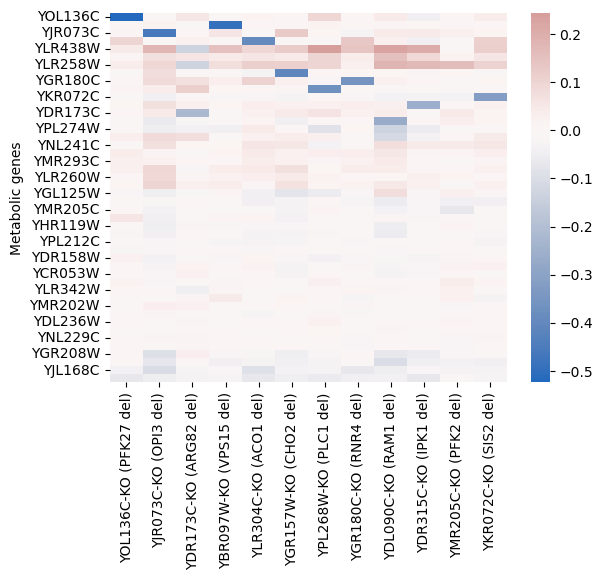

In [19]:
def plot_heatmap_metabolic(
    ax=None, 
    genes=ko_metabolic_genes, 
    conditions=selected_conditions, 
    cluster=True,
    yaxis_label = "Metabolic genes"
):
    #top_met_genes = df_ratio_all.loc[met_genes].std(axis=1).sort_values(ascending=False).head(100).index
    df_cluster = df_ratio_all.loc[list(genes), list(conditions)].copy()
    condition_names = []
    for c in df_cluster.columns:
        condition_names.append(f"{mapped_col_genes[c][1]}-KO ({mapped_col_genes[c][0]} del)")
    df_cluster.columns = condition_names
    df_cluster.index.name = yaxis_label
    if cluster:
        from scipy.cluster import hierarchy
        row_linkage = hierarchy.linkage(df_cluster, method='average')
        col_linkage = hierarchy.linkage(df_cluster.T, method='average')
        row_order = hierarchy.leaves_list(row_linkage)
        col_order = hierarchy.leaves_list(col_linkage)
        df_cluster = df_cluster.iloc[row_order, col_order]
    sns.heatmap(df_cluster, center=0, cmap="vlag", ax=ax)
    
#plot_heatmap_metabolic(genes=df_ratio_all.loc[met_genes].std(axis=1).sort_values(ascending=False).head(25).index)
plot_heatmap_metabolic()

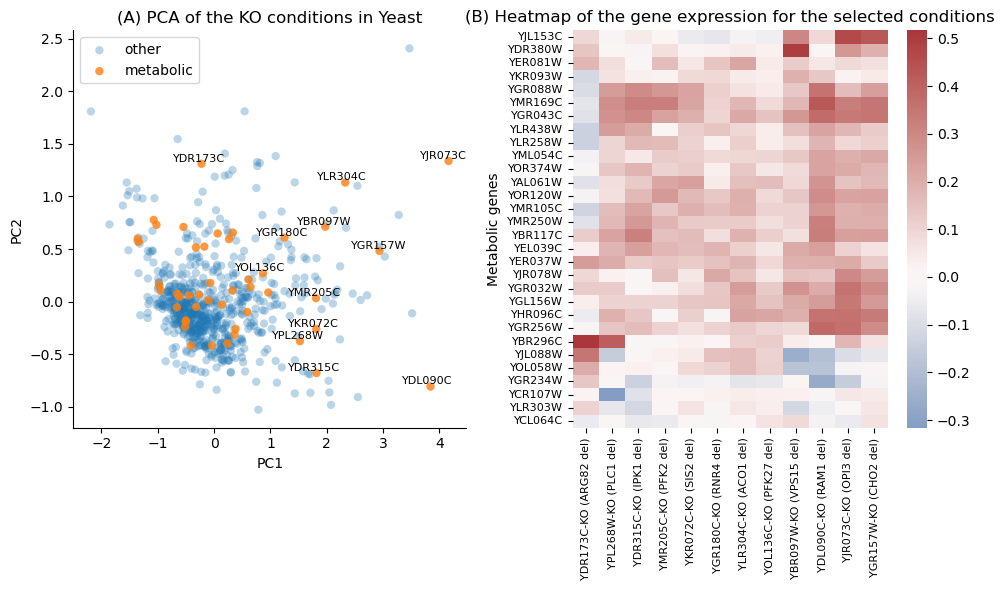

In [20]:
def adjust_spines_and_ticks(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
df_ratio_all_mlabels = df_ratio_all.T.copy()
new_index = [mapped_col_genes[c][1] for c in df_ratio_all_mlabels.index]
df_ratio_all_mlabels = df_ratio_all_mlabels.reset_index(drop=True)
df_ratio_all_mlabels["condition"] = new_index
df_ratio_all_mlabels = df_ratio_all_mlabels.dropna().set_index("condition")

df_ratio_all_mlabels["label"] = "other"
df_ratio_all_mlabels["gene"] = df_ratio_all_mlabels.index.values
selected_condition_metabolic_genes = [mapped_col_genes[c][1] for c in selected_conditions]
df_ratio_all_mlabels.loc[df_ratio_all_mlabels.index.isin(ko_metabolic_genes), "label"] = "metabolic"
df_ratio_all_mlabels.loc[~df_ratio_all_mlabels.index.isin(selected_condition_metabolic_genes), "gene"] = ""

pca = PCA(n_components=2) 
pca_result = pca.fit_transform(df_ratio_all_mlabels.drop(["label","gene"], axis=1))
pca_df = pd.DataFrame(data = pca_result, columns = ['PC1', 'PC2'])
pca_df["label"] = df_ratio_all_mlabels["label"].values
pca_df["alpha"] = pca_df["label"].apply(lambda x: 0.3 if x == "other" else 0.8)
pca_df["gene"] = df_ratio_all_mlabels["gene"].values

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
ax1 = axs[0]
ax2 = axs[1]

for ax in axs:
    adjust_spines_and_ticks(ax)

for label in pca_df['label'].unique():
    subset = pca_df[pca_df['label'] == label]
    sns.scatterplot(x="PC1", y="PC2", data=subset, label=label, 
                    alpha=subset['alpha'].iloc[0], edgecolor='none', ax=ax1)
    
for i in range(len(pca_df)):
    if len(pca_df['gene'][i]) > 0:
        ax1.text(x=pca_df['PC1'][i] - 0.5,
                 y=pca_df['PC2'][i] + 0.02,
                 s=pca_df['gene'][i],
                 fontdict=dict(color='black', size=8))
            

plot_heatmap_metabolic(genes=df_ratio_all.loc[met_genes].std(axis=1).sort_values(ascending=False).head(30).index, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=8)  # Change 12 to your desired size
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=8)  # Change 12 to your desired size

ax1.set_title("(A) PCA of the KO conditions in Yeast")
ax2.set_title("(B) Heatmap of the gene expression for the selected conditions")

fig.tight_layout()

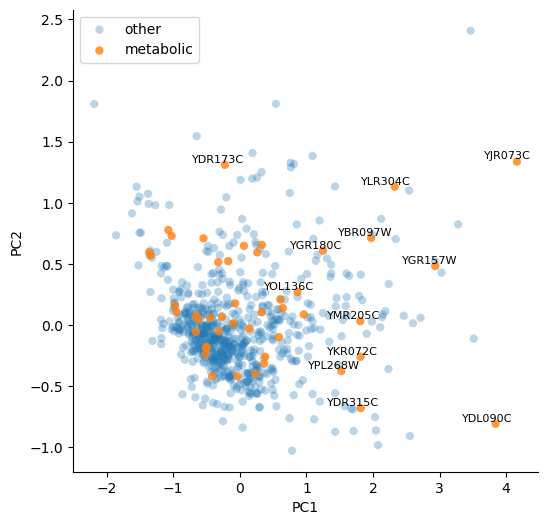

In [21]:
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(df_ratio_all_mlabels.drop(["label","gene"], axis=1))
pca_df = pd.DataFrame(data = pca_result, columns = ['PC1', 'PC2'])
pca_df["label"] = df_ratio_all_mlabels["label"].values
pca_df["alpha"] = pca_df["label"].apply(lambda x: 0.3 if x == "other" else 0.8)
pca_df["gene"] = df_ratio_all_mlabels["gene"].values


# Create a figure
fig, ax = plt.subplots(figsize=(6,6))
adjust_spines_and_ticks(ax)

for label in pca_df['label'].unique():
    subset = pca_df[pca_df['label'] == label]
    sns.scatterplot(x="PC1", y="PC2", data=subset, label=label, 
                    alpha=subset['alpha'].iloc[0], edgecolor='none', ax=ax)
    
for i in range(len(pca_df)):
    if len(pca_df['gene'][i]) > 0:
        ax.text(x=pca_df['PC1'][i] - 0.5,
                y=pca_df['PC2'][i] + 0.02,
                s=pca_df['gene'][i],
                fontdict=dict(color='black', size=8))
        
plt.savefig('output/metabolic_pca.pdf', format='pdf', bbox_inches='tight')

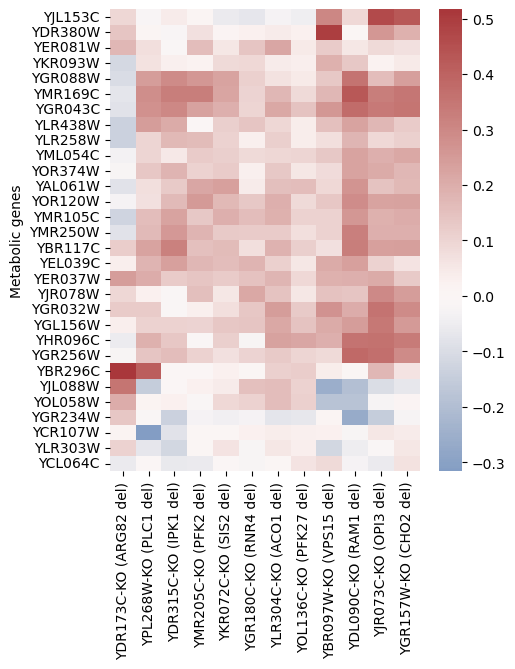

In [22]:
fig, ax = plt.subplots(figsize=(5, 6))
plot_heatmap_metabolic(genes=df_ratio_all.loc[met_genes].std(axis=1).sort_values(ascending=False).head(30).index, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10);
plt.savefig('output/metabolic_ko_heatmap.pdf', format='pdf', bbox_inches='tight')

In [23]:
df_ratio_all.loc[met_genes].to_csv("output/ma_ratio_metabolism.csv")

## Prepare data for metabolic network inference

Methods that infer metabolic networks from gene expression data rely on thresholds on gene expression to classify genes as active or inactive. In CORNETO, we extended the iMAT method for joint inference across conditions. The iMAT method requires user defined thresholds for this classification, e.g. see https://opencobra.github.io/cobratoolbox/stable/modules/dataIntegration/transcriptomics/iMAT/index.html


In [24]:
pval_th, th_qhigh, th_qlow

(0.01, 0.046599633791949036, -0.03876002403559884)

In [25]:
df_mvals_input = df_mvals.loc[met_genes, selected_conditions]
df_pvals_input = df_pvals.loc[met_genes, selected_conditions]
df_ratio_input = df_ratio.loc[met_genes, selected_conditions]
df_th_input = ((df_pvals_input <= pval_th) & ((df_ratio_input >= th_qhigh) | (df_ratio_input <= th_qlow))).astype(int)

df_input = ((df_ratio_input >= th_qhigh).astype(int) - (df_ratio_input <= th_qlow).astype(int)) * (df_pvals_input <= pval_th).astype(int)
df_input

,opi3-del vs. wt,ram1-del vs. wt,cho2-del vs. wt,aco1-del vs. wt,pfk2-del vs. wt,ipk1-del vs. wt,vps15-del vs. wt,sis2-del vs. wt,arg82-del vs. wt,plc1-del vs. wt,rnr4-del vs. wt,pfk27-del vs. wt
systematicName,,,,,,,,,,,,
YAL012W,-1,-1,0,0,0,0,0,0,0,0,0,0
YAL022C,0,0,0,0,0,0,0,0,0,0,0,0
YAL023C,0,0,0,0,0,0,0,0,0,0,0,0
YAL026C,0,0,0,0,0,0,0,0,0,0,0,0
YAL035W,-1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
YPR167C,0,0,0,0,0,0,0,0,1,0,0,0
YPR183W,1,0,0,0,0,0,0,0,0,0,0,0
YPR184W,1,1,1,1,1,1,1,1,0,1,1,1


In [26]:
df_input_continuous = df_th_input * df_ratio_input
df_input_continuous

,opi3-del vs. wt,ram1-del vs. wt,cho2-del vs. wt,aco1-del vs. wt,pfk2-del vs. wt,ipk1-del vs. wt,vps15-del vs. wt,sis2-del vs. wt,arg82-del vs. wt,plc1-del vs. wt,rnr4-del vs. wt,pfk27-del vs. wt
systematicName,,,,,,,,,,,,
YAL012W,-0.054647,-0.065936,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
YAL022C,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
YAL023C,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
YAL026C,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000
YAL035W,-0.055550,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
YPR167C,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.118054,-0.000000,0.000000,0.000000
YPR183W,0.098118,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000
YPR184W,0.247261,0.243996,0.178800,0.159157,0.099541,0.146166,0.105932,0.126221,-0.000000,0.092644,0.135172,0.076097


In [27]:
# Total number of genes that are high/low
df_input_summary = pd.DataFrame(df_input.abs().sum(axis=0), columns=["total"])
df_input_summary["low"] = (df_input < 0).sum(axis=0)
df_input_summary["high"] = (df_input > 0).sum(axis=0)
df_input_summary["p_low"] = df_input_summary["low"] / df_input_summary["total"]
df_input_summary["p_high"] = df_input_summary["high"] / df_input_summary["total"]
df_input_summary

,total,low,high,p_low,p_high
opi3-del vs. wt,549,196,353,0.357013,0.642987
ram1-del vs. wt,441,173,268,0.392290,0.607710
cho2-del vs. wt,358,97,261,0.270950,0.729050
aco1-del vs. wt,355,121,234,0.340845,0.659155
pfk2-del vs. wt,231,34,197,0.147186,0.852814
ipk1-del vs. wt,224,87,137,0.388393,0.611607
vps15-del vs. wt,222,59,163,0.265766,0.734234
sis2-del vs. wt,216,71,145,0.328704,0.671296
arg82-del vs. wt,208,112,96,0.538462,0.461538
plc1-del vs. wt,205,64,141,0.312195,0.687805


## Mapping reaction scores to the network

CORNETO implements a Gene-Protein-Reaction parser to map the gene expression onto the network, assigning a score per reaction. This is a common pre-processing step. See for example the one in Matlab COBRA toolbox: https://opencobra.github.io/cobratoolbox/stable/modules/dataIntegration/transcriptomics/preprocessing/index.html

In [28]:
from corneto.methods.metabolism import evaluate_gpr_rules
gpr_expressions = df_yeastn["Gene-reaction association"].values.tolist()

df_input_data = pd.DataFrame(
    evaluate_gpr_rules(gpr_expressions, [df_input.loc[:, c].to_dict() for c in df_input.columns]), 
    columns=df_yeastn["Rxn name"],
    index = df_input.columns
).T
df_input_data

,opi3-del vs. wt,ram1-del vs. wt,cho2-del vs. wt,aco1-del vs. wt,pfk2-del vs. wt,ipk1-del vs. wt,vps15-del vs. wt,sis2-del vs. wt,arg82-del vs. wt,plc1-del vs. wt,rnr4-del vs. wt,pfk27-del vs. wt
Rxn name,,,,,,,,,,,,
r_0001,1,1,1,1,0,0,1,1,0,0,1,0
r_0002,0,0,0,0,0,0,0,0,0,0,0,0
r_0003,0,1,0,1,1,1,0,1,-1,0,0,0
r_0004,1,1,1,1,1,1,1,1,0,1,1,1
r_0005,1,1,1,1,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
r_4694,0,0,0,0,0,0,0,0,0,0,0,0
r_4695,0,0,0,0,0,0,0,0,0,0,0,0
r_4697,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df_input_data = pd.DataFrame(
    evaluate_gpr_rules(gpr_expressions, [df_input.loc[:, c].to_dict() for c in df_input.columns]), 
    columns=df_yeastn["Rxn name"],
    index = df_input.columns
).T
df_input_data

,opi3-del vs. wt,ram1-del vs. wt,cho2-del vs. wt,aco1-del vs. wt,pfk2-del vs. wt,ipk1-del vs. wt,vps15-del vs. wt,sis2-del vs. wt,arg82-del vs. wt,plc1-del vs. wt,rnr4-del vs. wt,pfk27-del vs. wt
Rxn name,,,,,,,,,,,,
r_0001,1,1,1,1,0,0,1,1,0,0,1,0
r_0002,0,0,0,0,0,0,0,0,0,0,0,0
r_0003,0,1,0,1,1,1,0,1,-1,0,0,0
r_0004,1,1,1,1,1,1,1,1,0,1,1,1
r_0005,1,1,1,1,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
r_4694,0,0,0,0,0,0,0,0,0,0,0,0
r_4695,0,0,0,0,0,0,0,0,0,0,0,0
r_4697,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df_input_data_c = pd.DataFrame(
    evaluate_gpr_rules(gpr_expressions, [df_input_continuous.loc[:, c].to_dict() for c in df_input.columns]), 
    columns=df_yeastn["Rxn name"],
    index = df_input.columns
).T
df_input_data_c

,opi3-del vs. wt,ram1-del vs. wt,cho2-del vs. wt,aco1-del vs. wt,pfk2-del vs. wt,ipk1-del vs. wt,vps15-del vs. wt,sis2-del vs. wt,arg82-del vs. wt,plc1-del vs. wt,rnr4-del vs. wt,pfk27-del vs. wt
Rxn name,,,,,,,,,,,,
r_0001,0.095230,0.124747,0.061433,0.099614,0.000000,-0.000000,0.080204,0.068118,-0.000000,0.000000,0.049236,0.000000
r_0002,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
r_0003,-0.000000,0.084165,-0.000000,0.052861,0.112300,0.080038,0.000000,0.082683,-0.040418,0.000000,0.000000,0.000000
r_0004,0.106277,0.227319,0.061433,0.096725,0.124457,0.049974,0.132340,0.115789,0.000000,0.099367,0.085332,0.053543
r_0005,0.356620,0.203843,0.295076,0.244583,0.000000,-0.000000,0.269570,0.075129,0.121762,0.120263,0.135521,0.127155
...,...,...,...,...,...,...,...,...,...,...,...,...
r_4694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r_4695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r_4697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
df_rxn_input_summary = pd.DataFrame(df_input_data.abs().sum(axis=0), columns=["total"])
df_rxn_input_summary["low"] = (df_input_data < 0).sum(axis=0)
df_rxn_input_summary["high"] = (df_input_data > 0).sum(axis=0)
df_rxn_input_summary["p_low"] = df_rxn_input_summary["low"] / df_rxn_input_summary["total"]
df_rxn_input_summary["p_high"] = df_rxn_input_summary["high"] / df_rxn_input_summary["total"]
df_rxn_input_summary["p_low_total"] = df_rxn_input_summary["low"] / df_input_data.shape[0]
df_rxn_input_summary["p_high_total"] = df_rxn_input_summary["high"] / df_input_data.shape[0]
df_rxn_input_summary

,total,low,high,p_low,p_high,p_low_total,p_high_total
opi3-del vs. wt,1322,300,1022,0.226929,0.773071,0.073928,0.251848
ram1-del vs. wt,1184,263,921,0.222128,0.777872,0.064810,0.226959
cho2-del vs. wt,884,179,705,0.202489,0.797511,0.044110,0.173731
aco1-del vs. wt,690,150,540,0.217391,0.782609,0.036964,0.133070
pfk2-del vs. wt,490,59,431,0.120408,0.879592,0.014539,0.106210
ipk1-del vs. wt,432,120,312,0.277778,0.722222,0.029571,0.076885
vps15-del vs. wt,536,81,455,0.151119,0.848881,0.019961,0.112124
sis2-del vs. wt,422,93,329,0.220379,0.779621,0.022918,0.081074
arg82-del vs. wt,477,257,220,0.538784,0.461216,0.063332,0.054214
plc1-del vs. wt,336,79,257,0.235119,0.764881,0.019468,0.063332


In [32]:
df_input_data.to_csv("output/input_data.csv")
df_input_data_c.to_csv("output/input_data_cont.csv")
df_rxn_input_summary.to_csv("output/input_data_summary.csv")